In [26]:
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
import pickle
import json
import itertools
from mpl_toolkits import mplot3d

import seaborn as sns; sns.set()
sns.set_style("whitegrid")

In [27]:
import numpy as np
import matplotlib. pyplot as plt

def get_hypervolume(scores):
    """Computes the hypervolume of pareto front:
    Arguments:
        scores - the pareto front
    The higer the volume the better the pareto set.
    """
    scores = -scores
    hv = hypervolume(scores)
    d = scores.shape[1]
    return hv.compute([0.0]*d)
    
def is_dominated(p, S):
    """Helper function.
    """
    for s in S:
        if(np.all(s>=p)):
            return True
    return False

def coverage(S1, S2):
    """Computes the coverage scores.
    Arguments:
        S1 - one pareto front.
        S2 - another pareto front.
        
    coverage(S1, S2) gives the proportion of points in S2 weakly dominated by at least one point in S1
    """
    count = 0
    for s in S2:
        if(is_dominated(s, S1)):
            count = count + 1
    return(count/len(S2))

def distance_to_closest_neighbor(s, scores):
    """Helper function.
    """
    min_distance = 2*scores.shape[1]
    for s_j in scores:
        distance = np.sum(abs(s_j - s))
        if(distance < min_distance):
            min_distance = distance
    return(min_distance)


def spacing(scores):
    """Computes the spacing score.
    Arguments:
        scores - the pareto front
    """
    distances = []
    for i, s in enumerate(scores):
        d_i = distance_to_closest_neighbor(s, np.delete(scores, i, axis=0))
        distances.append(d_i)
        # print(d_i)
    distances = np.array(distances)
    d_mean = np.mean(distances)
    
    total=0
    for d in distances:
        total+=((d-d_mean)*(d-d_mean))
    return np.sqrt(total/float(len(scores) - 1))

In [28]:
def identify_pareto(scores):
    # Count number of items
    population_size = scores.shape[0]
    # Create a NumPy index for scores on the pareto front (zero indexed)
    population_ids = np.arange(population_size)
    # Create a starting list of items on the Pareto front
    # All items start off as being labelled as on the Parteo front
    pareto_front = np.ones(population_size, dtype=bool)
    # Loop through each item. This will then be compared with all other items
    for i in range(population_size):
        # Loop through all other items
        for j in range(population_size):
            # Check if our 'i' pint is dominated by out 'j' point
            if all(scores[j] >= scores[i]) and any(scores[j] > scores[i]):
                # j dominates i. Label 'i' point as not on Pareto front
                pareto_front[i] = 0
                # Stop further comparisons with 'i' (no more comparisons needed)
                break
    # Return ids of scenarios on pareto front
    return population_ids[pareto_front]

def get_pareto_points(metric1, metric2):

    scores = np.transpose(np.array([metric1, metric2]))

    x = scores[:, 1]
    y = scores[:, 0]
    
    pareto = identify_pareto(scores)
    pareto_front = scores[pareto]
    
    pareto_front_df = pd.DataFrame(pareto_front)
    pareto_front_df.sort_values(0, inplace=True)
    pareto_front = pareto_front_df.values
    
    x_all = scores[:, 1]
    y_all = scores[:, 0]
    x_pareto = pareto_front[:, 1]
    y_pareto = pareto_front[:, 0]
    
    return x_pareto, y_pareto

def get_pareto_points3(metric1, metric2, metrics3):

    scores = np.transpose(np.array([metric1, metric2, metrics3]))

    x = scores[:, 0]
    y = scores[:, 1]
    z = scores[:, 2]
    
    pareto = identify_pareto(scores)
    pareto_front = scores[pareto]
    
    pareto_front_df = pd.DataFrame(pareto_front)
    pareto_front_df.sort_values(0, inplace=True)
    pareto_front = pareto_front_df.values
    
    x_all = scores[:, 0]
    y_all = scores[:, 1]
    z_all = scores[:, 2]
    x_pareto = pareto_front[:, 0]
    y_pareto = pareto_front[:, 1]
    z_pareto = pareto_front[:, 2]
    
    return x_pareto, y_pareto, z_pareto

In [29]:
def plot_one(file_name, new_format=True):
    with open(file_name) as f:
        log_file = f.readlines()
    lines = [x for x in log_file if x.startswith("Trainer: Epoch:")]
    losses = [float(x.split()[8][:-1]) for x in lines]
    if not new_format:
        recall = [float(x.split()[14][1:-1]) for x in lines]
        revenue = [float(x.split()[15][:-2]) for x in lines]
    else:
        recall = [float(x.split()[18][1:-1]) for x in lines]
        revenue = [float(x.split()[19][:-2]) for x in lines]
        loss1 = [float(x.split()[11][1:-1]) for x in lines]
        loss2 = [float(x.split()[12][:-1]) for x in lines]
        
    
    plt.plot(losses)
    plt.ylabel("loss")
    plt.show()
    
    if new_format:
        plt.plot(loss1)
        plt.ylabel("loss 1")
        plt.show()

        plt.plot(loss2)
        plt.ylabel("loss 2")
        plt.show()

    plt.plot(recall)
    plt.ylabel("Recall@20")
    plt.show()

    plt.plot(revenue)
    plt.ylabel("Revenue@20")
    plt.show()


In [30]:
def plot_two(file_name1, file_name2, new_format=True):
    with open(file_name1) as f:
        log_file = f.readlines()
    lines = [x for x in log_file if x.startswith("Trainer: Epoch:")]
    losses1 = [float(x.split()[8][:-1]) for x in lines]
    if not new_format:
        recall1 = [float(x.split()[14][1:-1]) for x in lines]
        revenue1 = [float(x.split()[15][:-2]) for x in lines]
    else:
        recall1 = [float(x.split()[18][1:-1]) for x in lines]
        revenue1 = [float(x.split()[19][:-2]) for x in lines]
        loss1_1 = [float(x.split()[11][1:-1]) for x in lines]
        loss1_2 = [float(x.split()[12][:-1]) for x in lines]
    
    with open(file_name2) as f:
        log_file = f.readlines()
    lines = [x for x in log_file if x.startswith("Trainer: Epoch:")]
    losses2 = [float(x.split()[8][:-1]) for x in lines]
    if not new_format:
        recall2 = [float(x.split()[14][1:-1]) for x in lines]
        revenue2 = [float(x.split()[15][:-2]) for x in lines]
    else:
        recall2 = [float(x.split()[18][1:-1]) for x in lines]
        revenue2 = [float(x.split()[19][:-2]) for x in lines]
        loss2_1 = [float(x.split()[11][1:-1]) for x in lines]
        loss2_2 = [float(x.split()[12][:-1]) for x in lines]
    
    plt.plot(losses1, color='b', label="Adamized SMSGD")
    plt.plot(losses2, color='y', label="Vanilla SMSGD")
    plt.ylabel("Loss")
    plt.xlabel("Epcoh")
    legend = plt.legend()
    plt.savefig(PLOTS_DIR + "/1_loss.png", dpi=200)
    plt.show()
    
    if  new_format:
        plt.plot(loss1_1, color='b', label="Adamized SMSGD")
        plt.plot(loss2_1, color='y', label="Vanilla SMSGD")
        plt.ylabel("Relevance loss")
        plt.xlabel("Epcoh")
        legend = plt.legend()
        plt.savefig(PLOTS_DIR + "/2_relevance_loss.png", dpi=200)
        plt.show()
        
        plt.plot(loss1_2, color='b', label="Adamized SMSGD")
        plt.plot(loss2_2, color='y', label="Vanilla SMSGD")
        plt.ylabel("Revenue loss")
        plt.xlabel("Epcoh")
        legend = plt.legend()
        plt.savefig(PLOTS_DIR + "/3_revenue_loss.png", dpi=200)
        plt.show()

    plt.plot(recall1, color='b', label="Adamized SMSGD")
    plt.plot(recall2, color='y', label="Vanilla SMSGD")
    plt.ylabel("Recall@20")
    plt.xlabel("Epcoh")
    legend = plt.legend()
    plt.savefig(PLOTS_DIR + "/4_recall.png", dpi=200)
    plt.show()

    plt.plot(revenue1, color='b', label="Adamized SMSGD")
    plt.plot(revenue2, color='y', label="Vanilla SMSGD")
    plt.ylabel("Revenue@20")
    plt.xlabel("Epcoh")
    legend = plt.legend()
    plt.savefig(PLOTS_DIR + "/5_revenue.png", dpi=200)
    plt.show()
    
    plot_two_pareto(recall1, revenue1, recall2, revenue2)

In [31]:
def clean_line(line):
    parts = line.split(" ")
    parts = parts[4:]
    return " ".join(parts)

training_loss_q = "Training loss: "
training_losses_q = "Training losses: "
validation_metrics_q = "Validation metrics: "

def search_term(line, query):
    start = line.find(query)
    start += len(query)
    # single number
    if line[start] != "[":
        subline = line[start:]
        end = subline.find(", ")
        return float(subline[:end])
    else:
        subline = line[start:]
        end = subline.find("]")
        subline = subline[:end+1]
        return json.loads(subline)

In [32]:
def read_metrics(file_name):
    with open(file_name) as f:
        log_file = f.readlines()
    log_file = [clean_line(x) for x in log_file]
    lines = [x for x in log_file if x.startswith("Trainer: Epoch:")]
    # extract metrics
    metrics = [search_term(x, "Validation metrics: ") for x in lines]
    return metrics

In [33]:
def plot_two_pareto(recall1, revenue1, recall2, revenue2, label1, label2, name):
    pareto_new = get_pareto_points(recall1, revenue1)
    pareto_original = get_pareto_points(recall2, revenue2)
    
    plt.plot(pareto_original[0], pareto_original[1], color='y', label="Vanilla SMSGD")
    plt.scatter(pareto_original[0], pareto_original[1], color="olive")

    plt.plot(pareto_new[0], pareto_new[1], color='b', label="Ensemble Model")
    plt.scatter(pareto_new[0], pareto_new[1], color="darkblue")
    
    x_org = [revenue1[0], revenue1[-1]]
    y_org = [recall1[0], recall1[-1]]
    plt.scatter(x_org, y_org, marker="*", color='orange', label="Single Obj. Models")

    plt.xlabel(label2)
    plt.ylabel(label1)
    # legend = plt.legend(loc='upper center', shadow=True, fontsize='x-large')
    legend = plt.legend()
    plt.savefig(PLOTS_DIR + "/" + name, dpi=200)
    plt.show()
    
    pareto_original = np.array(list(zip(pareto_original[0], pareto_original[1])))
    pareto_new = np.array(list(zip(pareto_new[0], pareto_new[1])))
    print("Hypervolume of original: {}".format(get_hypervolume(pareto_original)))
    print("Hypervolume of new: {}".format(get_hypervolume(pareto_new)))
    print("Coverage of original over new: {}".format(coverage(pareto_original, pareto_new)))
    print("Coverage of new over original: {}".format(coverage(pareto_new, pareto_original)))
    print("Spacing of original: {}".format(spacing(pareto_original)))
    print("Spacing of new: {}".format(spacing(pareto_new)))

In [34]:
def plot_pareto(PF_new, PF_original, i, j, label1, label2, name):
    scores_new = np.array(PF_new)
    scores_original = np.array(PF_original)

    recall1 = scores_new[:, i]
    revenue1 = scores_new[:, j]
    
    recall2 = scores_original[:, i]
    revenue2 = scores_original[:, j]

    plot_two_pareto(recall1, revenue1, recall2, revenue2, label1, label2, name)

In [35]:
PLOTS_DIR = "plots_FINAL_ADAMIZE"
if not os.path.exists(PLOTS_DIR):
    os.mkdir(PLOTS_DIR)

# ADAMIZE 3 OBJECTIVES

In [36]:
def plot_and_compute(adamize_file, plot=False):
    adamize_metrics = read_metrics(os.path.join("logs_adam_per_obj_final", adamize_file))
    print(os.path.join("logs_adam_per_obj_final", adamize_file))
    MO_cor_rev = read_metrics("MO_cor_rev_rec_2020-07-27_14-37-37.log")
    
    scores_new = np.array(adamize_metrics)
    scores_original = np.array(MO_cor_rev)

    recall1 = scores_new[:, 0]
    revenue1 = scores_new[:, 1]
    recency1 = scores_new[:, 2]

    recall2 = scores_original[:, 0]
    revenue2 = scores_original[:, 1]
    recency2 = scores_original[:, 2]
    
    recall1, revenue1, recency1 = get_pareto_points3(recall1, revenue1, recency1)
    recall2, revenue2, recency2 = get_pareto_points3(recall2, revenue2, recency2)
    
    pareto_new = np.array(list(zip(recall1, revenue1, recency1)))
    pareto_original = np.array(list(zip(recall2, revenue2, recency2)))
    print("Hypervolume of original: {}".format(get_hypervolume(pareto_original)))
    print("Hypervolume of new: {}".format(get_hypervolume(pareto_new)))
    print("Coverage of original over new: {}".format(coverage(pareto_original, pareto_new)))
    print("Coverage of new over original: {}".format(coverage(pareto_new, pareto_original)))
    print("Spacing of original: {}".format(spacing(pareto_original)))
    print("Spacing of new: {}".format(spacing(pareto_new)))
    print('#'*150)
    
    if plot:
        for c, angle in enumerate([[10, 60], [50, 60], [20, 60], [60, 35]]):
            fig = plt.figure()
            ax = plt.axes(projection='3d')
            ax.view_init(angle[0], angle[1])

            # depthshade=False
            ax.scatter3D(recall1, revenue1, recency1, color='b', label="Ensemble Model")
            ax.scatter3D(recall2, revenue2, recency2, color='y', label="Vanilla SMSGD")
            ax.set_xlabel('Recall@20')
            ax.set_ylabel('Revenue@20')
            ax.set_zlabel('Recency@20')
            plt.savefig(PLOTS_DIR + "/pareto_front_3_{}.png".format(c), dpi=200)
            plt.show()
            
    return get_hypervolume(pareto_new), coverage(pareto_new, pareto_original)

In [79]:
def plot_and_compute_(adamize_file, plot=False):
    adamize_metrics = read_metrics(os.path.join("logs_adam_per_obj_final", adamize_file))
    print(os.path.join("logs_adam_per_obj_final", adamize_file))
    MO_cor_rev = read_metrics("MO_cor_rev_rec_2020-07-27_14-37-37.log")
    
    scores_new = np.array(adamize_metrics)
    scores_original = np.array(MO_cor_rev)

    recall1 = scores_new[:, 0]
    revenue1 = scores_new[:, 1]
    recency1 = scores_new[:, 2]

    recall2 = scores_original[:, 0]
    revenue2 = scores_original[:, 1]
    recency2 = scores_original[:, 2]
    
    recall1, revenue1, recency1 = get_pareto_points3(recall1, revenue1, recency1)
    recall2, revenue2, recency2 = get_pareto_points3(recall2, revenue2, recency2)
    
    pareto_new = np.array(list(zip(recall1, revenue1, recency1)))
    pareto_original = np.array(list(zip(recall2, revenue2, recency2)))
    #print("Hypervolume of original: {}".format(get_hypervolume(pareto_original)))
    #print("Hypervolume of new: {}".format(get_hypervolume(pareto_new)))
    print("Coverage of original over new: {}".format(coverage(pareto_original, pareto_new)))
    print("Coverage of new over original: {}".format(coverage(pareto_new, pareto_original)))
    print("Spacing of original: {}".format(spacing(pareto_original)))
    print("Spacing of new: {}".format(spacing(pareto_new)))
    print('#'*150)
    
    c = 0
    labels = ["Recall@20", "Revenue@20", "Recency@20"]
    for i, j in [[0, 1], [0, 2], [1, 2]]:
        p1_o, p2_o = get_pareto_points(scores_original[:, i], scores_original[:, j])
        p1_n, p2_n = get_pareto_points(scores_new[:, i], scores_new[:, j])
        plt.plot(p1_o, p2_o, color='#1f77b4', linewidth=2, marker=".", linestyle='-', markersize=10, label='Vanilla SMSGD')
    
        plt.scatter(p1_o, p2_o, color="olive")
        plt.xlabel(labels[j], fontsize=18)
        plt.tick_params(labelsize=18)
        plt.ylabel(labels[i], fontsize=18)
        plt.plot(p1_n, p2_n, color='#ff7f0e', linewidth=2, marker="s", linestyle=':', markersize=7, label='Adamized SMSGD')
        plt.scatter(p1_n, p2_n, color="darkblue")
        
        plt.xlabel(labels[j], fontsize=18)
        plt.tick_params(labelsize=18)
        plt.ylabel(labels[i], fontsize=18)
        if i == 0 and j == 2:
            plt.ylim((0.33, 0.401))
        legend = plt.legend(prop={'size':14},loc='lower left')
        
        plt.savefig(PLOTS_DIR + "/pareto_front_3_projected_{}.pdf".format(c), bbox_inches='tight', dpi=300)
        plt.show()
        c += 1
    
#     if plot:
#         for c, angle in enumerate([[10, 60], [50, 60], [20, 60], [60, 35]]):
#             fig = plt.figure()
#             ax = plt.axes(projection='3d')
#             ax.view_init(angle[0], angle[1])

#             # depthshade=False
#             ax.scatter3D(recall1, revenue1, recency1, color='b', label="Ensemble Model")
#             ax.scatter3D(recall2, revenue2, recency2, color='y', label="Vanilla SMSGD")
#             ax.set_xlabel('Recall@20')
#             ax.set_ylabel('Revenue@20')
#             ax.set_zlabel('Recency@20')
#             plt.savefig(PLOTS_DIR + "/pareto_front_3_{}.png".format(c), dpi=200)
#             plt.show()
            
    return 0,0#get_hypervolume(pareto_new), coverage(pareto_new, pareto_original)

In [80]:
max(hypervolume_all)

0

In [81]:
max(coverage_all)

0

# FINAL FOR 3 OBJ

logs_adam_per_obj_final/MO_cor_rev_rec_2020-08-27_06-33-14.log
Coverage of original over new: 0.0
Coverage of new over original: 0.49382716049382713
Spacing of original: 0.14679191319982207
Spacing of new: 0.235272576350761
######################################################################################################################################################


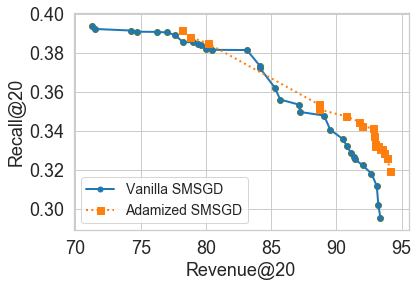

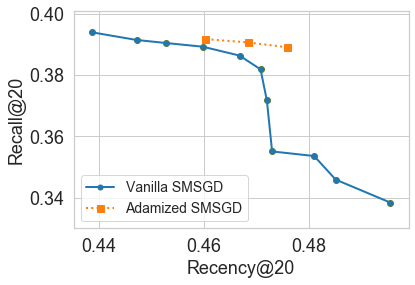

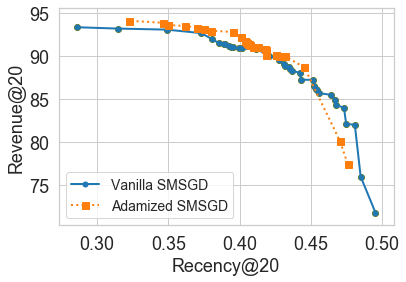

(0, 0)

In [82]:
plot_and_compute_("MO_cor_rev_rec_2020-08-27_06-33-14.log", True)